**Import required libraries for the FastAI model**

In [1]:
from fastai.imports import *
from fastai.vision.all import *
from fastai.vision.widgets import *

**Set the path to the training dataset**

In [2]:
PATH = "/kaggle/input/testset/data/train"
#os.chdir(PATH)
#os.listdir()
from PIL import Image
import numpy

**Load an example image from the dataset and display it**

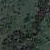

In [3]:
im = Image.open(PATH+"/no_pools/img1194.jpg")
im

**Define the DataBlock for the pool detection task**

* blocks = A tuple; ImageBlock is used to handle the image data and the CategoryBlock is used for the category (classification) label data.
* get_items = argument that specifies a function that returns a list of items to be used for training the model.
* splitter = argument specifies a function that splits the data into training and validation sets. In this case, RandomSplitter is used to randomly split the data with 20% going to the validation set and 80% to the training set. seed=42 sets a seed value for the random number generator so that the same split is used every time.
* get_y = argument specifies a function that returns the label for each item. In this case, parent_label is used to get the parent directory name of the image file, which is used as the label.
* item_tfms = argument specifies a list of transforms to be applied to each item (image) in the dataset. Resize is used to resize the image to a height and width of 50 pixels.
* The batch_tfms argument specifies a list of transforms to be applied to each batch of images during training. In this case, aug_transforms is used to apply a set of augmentations (random transformations) to the images. mult=1.0 specifies the degree of augmentation to apply, do_flip=True enables random horizontal flipping of images, max_rotate=45.0 specifies the maximum degree of rotation to apply, and max_lighting=0.4 specifies the maximum amount of lighting changes to apply.

In [4]:
poolDetection = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(50),
    batch_tfms=aug_transforms(mult=1.0, do_flip=True,max_rotate=45.0,max_lighting=0.4))

**Create dataloaders for the pool detection dataset**

In [5]:
dls = poolDetection.dataloaders(PATH)

**Display a batch of validation images**

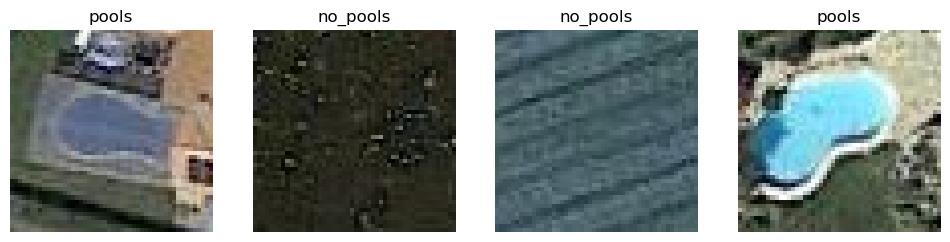

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

**Create a CNN learner using the ResNet18 architecture**

In [7]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/model

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**Running the lerning rate finder to get the best suggested lerning rates and extract the suggested learning rate corresponding to the vallay for the loss curve**

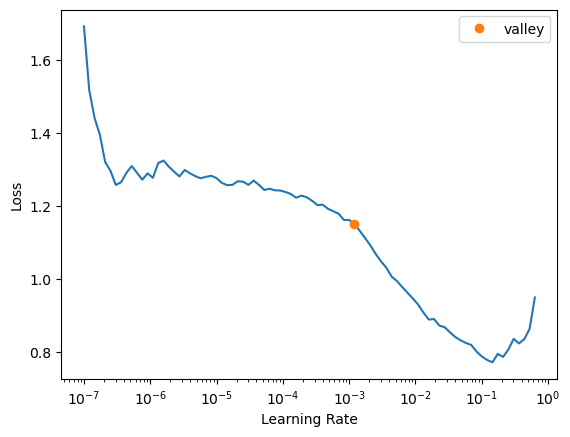

In [8]:
suggested_lrs = learn.lr_find()
lr_min = suggested_lrs.valley

**Setting the number of epochs for the fine tuning of the model, and then fine tune the model using the n_epochs and the suggested lerningrate we found over**

In [9]:
n_epochs = 7 # epochs you like to use
learn.fine_tune(n_epochs, base_lr=lr_min)

epoch,train_loss,valid_loss,error_rate,time
0,0.716104,0.437036,0.128676,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.457778,0.291014,0.091912,00:08
1,0.388106,0.247909,0.080882,00:06
2,0.320327,0.314821,0.071691,00:06
3,0.264545,0.219611,0.056985,00:07
4,0.217975,0.197459,0.056985,00:07
5,0.191412,0.194064,0.051471,00:06
6,0.166101,0.200379,0.051471,00:06


In [10]:
learn.unfreeze()
learn.fit_one_cycle(5, lr_max=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.169795,0.165134,0.044118,00:06
1,0.148263,0.266927,0.051471,00:06
2,0.136467,0.103861,0.031250,00:07
3,0.113348,0.108980,0.034926,00:06
4,0.083586,0.114311,0.033088,00:06


**Visualize the model's performance with a confusion matrix**

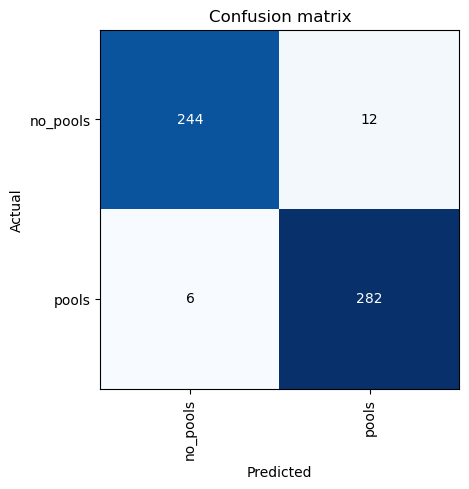

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**Display the top 5 losses**

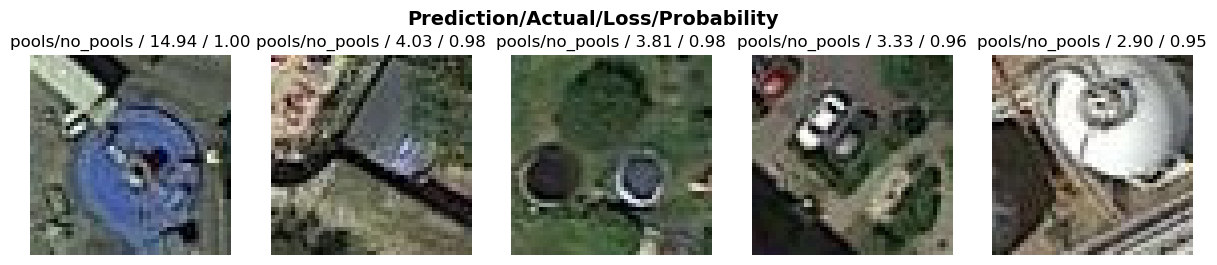

In [12]:
interp.plot_top_losses(5, nrows=1)

**Create an ImageClassifierCleaner for cleaning the dataset, if you want to do so**

In [13]:
cleaner = ImageClassifierCleaner(learn)
cleaner

After going through the dataset thoroughly i did not want to clean my dataset, but if you run this code bellow it's possible.

In [14]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

**Export the trained model**

In [15]:
learn.export('Pool-Detection-Model.pkl')